In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, log_evaluation, record_evaluation
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#from sklearn.impute import IterativeImputer
import pickle
import optuna
from optuna.visualization import plot_slice, plot_param_importances
import shap

gc.enable()

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [4]:
os.listdir(path)

['features.csv',
 'kaggle_evaluation',
 'lags.parquet',
 'my_folder',
 'responders.csv',
 'sample_submission.csv',
 'team_folder',
 'test.parquet',
 'train.parquet']

In [5]:
train_df = pl.read_parquet(path + 'train.parquet/').select(pl.all().shrink_dtype())
lags_df = train_df.with_columns(pl.col('date_id') + 1).drop(['weight', 'partition_id'] + [col for col in train_df.columns if 'feature' in col]).rename({f'responder_{x}': f'responder_{x}_lag_1' for x in range(9)})
train_df = train_df.drop(['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_7', 'responder_8', 'partition_id']).select(pl.all().shrink_dtype())
train_df = train_df.join(lags_df, on=['date_id', 'time_id', 'symbol_id'], how='left').select(pl.all().shrink_dtype())
del lags_df
gc.collect()
print(train_df.shape)
train_df.head()

(47127338, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,null,0.28118,0.269163,0.349028,-0.012596,-0.225932,null,-1.073602,null,null,-0.181716,null,null,null,0.564021,2.088506,0.832022,null,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498,0.775981,null,null,null,null,null,null,null,null,null
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,null,0.317467,null,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,null,null,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,null,null,null,null,null,null,null,null,-10.835207,-0.002704,-0.621836,null,1.172836,null,null,-1.625862,null,-1.410017,1.063013,null,0.888355,0.467994,-1.36224,null,null,null,null,null,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,null,null,-0.281207,-0.182894,-0.245565,-0.302441,0.703665,null,null,null,null,null,null,null,null,null
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,null,-0.814909,null,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,null,null,-0.320921,-0.95809,-2.436589,0.070999,-0.245239,null,null,null,null,null,null,null,null,-1.420632,-3.515137,-4.67776,null,0.535897,null,null,-0.72542,null,-2.29417,1.764551,null,-0.120789,-0.063458,-1.36224,null,null,null,null,null,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,null,null,0.377131,0.300724,-0.106842,-0.096792,2.109352,null,null,null,null,null,null,null,null,null
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,null,-0.251882,null,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,null,null,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,null,null,null,null,null,null,null,null,0.382074,2.669135,0.611711,null,2.413415,null,null,1.313203,null,-0.810125,2.939022,null,3.988801,1.834661,-1.36224,null,null,null,null,null,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,null,null,-0.226891,-0.251412,-0.215522,-

In [6]:
train_scan = pl.scan_parquet(path + 'train.parquet/')
test_scan = pl.scan_parquet(path + 'test.parquet/')

In [7]:
train_symbol_ids_list = sorted(train_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
test_symbol_ids_list = sorted(test_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
unique_symbol_ids_list = sorted(list(set(train_symbol_ids_list + test_symbol_ids_list)))
unique_symbol_ids_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [8]:
def one_hot_cat_cols(df):
    for v in tqdm(unique_symbol_ids_list):
        new_col_name = 'symbol_id_' + str(v)
        #df[new_col_name] = (df['symbol_id'] == v).astype(int)
        df = df.with_columns((pl.col('symbol_id') == v).cast(pl.Int8).alias(new_col_name))

    
    #df = df.drop('symbol_id', axis=1)

    return df.select(pl.all().shrink_dtype())

In [9]:
features_df = pl.read_csv(path + 'features.csv').select(pl.all().shrink_dtype())
responders_df = pl.read_csv(path + 'responders.csv').select(pl.all().shrink_dtype())

In [10]:
tags_list = features_df.columns
tags_list.remove('feature')

In [11]:
responder_tags_list = responders_df.columns
responder_tags_list.remove('responder')

In [12]:
def create_tag_features(df):
    for tag in tqdm(tags_list):
        tag_features = features_df.filter(pl.col(f"{tag}") == True)["feature"].to_list()
        df = df.with_columns(
            pl.sum_horizontal(tag_features).alias('feature_' + tag + '_sum'),
            pl.mean_horizontal(tag_features).alias('feature_' + tag + '_mean'),
            pl.min_horizontal(tag_features).alias('feature_' + tag + '_min'),
            pl.max_horizontal(tag_features).alias('feature_' + tag + '_max')
        )

    return df.select(pl.all().shrink_dtype())

In [13]:
def create_responders_tag_features(df):
    for tag in tqdm(responder_tags_list):
        tag_features = responders_df.filter(pl.col(f"{tag}") == True)["responder"].to_list()
        tag_features = [v + '_lag_1' for v in tag_features]
        df = df.with_columns(
            pl.sum_horizontal(tag_features).alias('responder_' + tag + '_sum'),
            pl.mean_horizontal(tag_features).alias('responder_' + tag + '_mean'),
            pl.min_horizontal(tag_features).alias('responder_' + tag + '_min'),
            pl.max_horizontal(tag_features).alias('responder_' + tag + '_max')
        )

    return df.select(pl.all().shrink_dtype())

In [14]:
train_df = create_tag_features(train_df)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:42<00:00,  2.51s/it]


In [15]:
train_df = create_responders_tag_features(train_df)
print(train_df.shape)
train_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


(47127338, 181)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1,feature_tag_0_sum,feature_tag_0_mean,feature_tag_0_min,feature_tag_0_max,feature_tag_1_sum,feature_tag_1_mean,feature_tag_1_min,feature_tag_1_max,feature_tag_2_sum,feature_tag_2_mean,feature_tag_2_min,feature_tag_2_max,feature_tag_3_sum,feature_tag_3_mean,feature_tag_3_min,feature_tag_3_max,feature_tag_4_sum,feature_tag_4_mean,feature_tag_4_min,feature_tag_4_max,feature_tag_5_sum,feature_tag_5_mean,feature_tag_5_min,feature_tag_5_max,feature_tag_6_sum,feature_tag_6_mean,feature_tag_6_min,feature_tag_6_max,feature_tag_7_sum,feature_tag_7_mean,feature_tag_7_min,feature_tag_7_max,feature_tag_8_sum,feature_tag_8_mean,feature_tag_8_min,feature_tag_8_max,feature_tag_9_sum,feature_tag_9_mean,feature_tag_9_min,feature_tag_9_max,feature_tag_10_sum,feature_tag_10_mean,feature_tag_10_min,feature_tag_10_max,feature_tag_11_sum,feature_tag_11_mean,feature_tag_11_min,feature_tag_11_max,feature_tag_12_sum,feature_tag_12_mean,feature_tag_12_min,feature_tag_12_max,feature_tag_13_sum,feature_tag_13_mean,feature_tag_13_min,feature_tag_13_max,feature_tag_14_sum,feature_tag_14_mean,feature_tag_14_min,feature_tag_14_max,feature_tag_15_sum,feature_tag_15_mean,feature_tag_15_min,feature_tag_15_max,feature_tag_16_sum,feature_tag_16_mean,feature_tag_16_min,feature_tag_16_max,responder_tag_0_sum,responder_tag_0_mean,responder_tag_0_min,responder_tag_0_max,responder_tag_1_sum,responder_tag_1_mean,responder_tag_1_min,responder_tag_1_max,responder_tag_2_sum,responder_tag_2_mean,responder_tag_2_min,responder_tag_2_max,responder_tag_3_sum,responder_tag_3_mean,responder_tag_3_min,responder_tag_3_max,responder_tag_4_sum,responder_tag_4_mean,responder_tag_4_min,responder_tag_4_max
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,f32,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,null,0.28118,0.269163,0.349028,-0.012596,-0.225932,null,-1.073602,null,null,-0.181716,null,null,null,0.564021,2.088506,0.832022,null,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.0

In [16]:
train_df.estimated_size() / 1e9

33.672483076

In [17]:
models_path = path + 'my_folder/models/20250105_10/'

In [18]:
def lgb_online_learning(train_data):
    weights = train_data['weight'].to_pandas()
    y = train_data['responder_6'].to_pandas()

    unique_date_ids = train_data['date_id'].unique()    
    train_date_id_cut = 1300

    print('max date:', unique_date_ids.max())
    print('date id cut:', train_date_id_cut)

    X_train = train_data.filter(pl.col('date_id') <= train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()#.sample(frac=0.01)
    X_val = train_data.filter(pl.col('date_id') > train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()

    print(X_train.shape[0] / train_data.shape[0])

    y_train = y.loc[X_train.index]
    y_val = y[-X_val.shape[0]:]

    weights_train = weights.loc[X_train.index]
    weights_val = weights[-X_val.shape[0]:]

    print(X_train.shape)
    display(X_train.head())
    display(X_train.tail())    

    #train_dataset = lgb.Dataset(data=X_train, label=y_train, weight=weights_train)
    #val_dataset = lgb.Dataset(data=X_val, label=y_val, weight=weights_val)

    base_params = {
        'verbosity': -1,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'device': 'gpu',
        'early_stopping_round': 30,
        'lambda_l2': 100,
        #'metric': 'r2',
        #'seed': 42
    }

    '''model = lgb.train(
        params=base_params,
        train_set=train_dataset,
        num_boost_round=90
    )'''

    model = LGBMRegressor(
        **base_params,
        n_estimators=90000
    )

    model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], callbacks=[log_evaluation(period=10)])#, init_model=current_model)
    #model.fit(X_train, y_train, sample_weight=weights_train)

    best_iteration = model.best_iteration_
    print(f"Best iteration: {best_iteration}")

    plt.figure()
    lgb.plot_metric(model)
    plt.ylim(0, 2)
    plt.show()

    val_preds = model.predict(X_val)

    print('Val Weighted R2 score is:', r2_score(y_val, val_preds, sample_weight=weights_val))

    return model

    sample_val = X_val.sample(frac=0.01)
    sample_y = y_val.iloc[sample_val.index]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X=sample_val, y=sample_y)
    shap_importance = np.abs(shap_values).mean(axis=0)

    return model, shap_importance










    

    val_date_ids = sorted(train_data.filter(pl.col('date_id') > train_date_id_cut)['date_id'].unique())
    
    for date_id_v in val_date_ids:
        for time_id_v in sorted(train_data.filter(pl.col('date_id') == date_id_v)['time_id'].unique()):
            time_id_df = train_data.filter((pl.col('date_id') == date_id_v) & (pl.col('time_id') == time_id_v))

            print(time_id_df.shape)
            display(time_id_df)

            time_id_X_train = time_id_df.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
            time_id_y_train = time_id_df['responder_6'].to_pandas()
            time_id_weights_train = time_id_df['weight'].to_pandas()

            val_data_df = train_data.filter(pl.col('date_id') >= date_id_v)[time_id_df.shape[0]:]

            return




    return
    
    '''weights = train_data['weight']
    y = train_data['responder_6']
    
    unique_date_ids = train_data['date_id'].unique()
    train_date_id_cut = int(unique_date_ids.max() - 10)

    print('max date:', unique_date_ids.max())
    print('date id cut:', train_date_id_cut)
    
    X_train = train_data.filter(pl.col('date_id') <= train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
    X_val = train_data.filter(pl.col('date_id') > train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()

    print(X_train.shape[0] / train_data.shape[0])
    
    y_train = y[:X_train.shape[0]].to_pandas()
    y_val = y[X_train.shape[0]:].to_pandas()
    
    weights_train = weights[:X_train.shape[0]].to_pandas()
    weights_val = weights[X_train.shape[0]:].to_pandas()

    print(X_train.shape)
    display(X_train.head())

    base_params = {
        'verbosity': -1,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'device': 'gpu',
        'early_stopping_round': 30,
        'lambda_l2': 100
    }
    
    model = LGBMRegressor(
        **base_params,
        n_estimators=100000
    )

    model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], callbacks=[log_evaluation(period=50)])#, categorical_feature=['symbol_id'])

    best_iteration = model.best_iteration_
    print(f"Best iteration: {best_iteration}")

    val_preds = model.predict(X_val)

    plt.figure()
    lgb.plot_metric(model)
    plt.ylim(0, 1)
    plt.show()    

    if not os.path.exists(models_path):
        os.makedirs(models_path)

    with open(models_path + "lgb_model.pkl", 'wb') as file:
        pickle.dump(model, file)

    print('Val Weighted R2 score is:', r2_score(y_val, val_preds, sample_weight=weights_val))

    sample_val = X_val.sample(frac=0.001)
    sample_y = y_val.loc[sample_val.index]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X=sample_val, y=sample_y)
    shap_importance = np.abs(shap_values).mean(axis=0)

    del X_train, y_train, X_val, y_val, weights_train, weights_val
    gc.collect()

    # Retraining on the full dataset using best_iteration
    X_full = train_data.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
    y_full = y.to_pandas()
    weights_full = weights.to_pandas()

    base_params.pop('early_stopping_round')

    model_full = LGBMRegressor(
        **base_params,
        n_estimators=best_iteration
    )
    
    model_full.fit(X_full, y_full, sample_weight=weights_full)

    with open(models_path + "lgb_model_full.pkl", 'wb') as file:
        pickle.dump(model_full, file)

    print("Retraining complete. Model saved as 'lgb_model_full.pkl'.")

    return shap_importance'''

max date: 1698
date id cut: 1300
0.6895364639521969
(32496018, 176)


,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1,feature_tag_0_sum,feature_tag_0_mean,feature_tag_0_min,feature_tag_0_max,feature_tag_1_sum,feature_tag_1_mean,feature_tag_1_min,feature_tag_1_max,feature_tag_2_sum,feature_tag_2_mean,feature_tag_2_min,feature_tag_2_max,feature_tag_3_sum,feature_tag_3_mean,feature_tag_3_min,feature_tag_3_max,feature_tag_4_sum,feature_tag_4_mean,feature_tag_4_min,feature_tag_4_max,feature_tag_5_sum,feature_tag_5_mean,feature_tag_5_min,feature_tag_5_max,feature_tag_6_sum,feature_tag_6_mean,feature_tag_6_min,feature_tag_6_max,feature_tag_7_sum,feature_tag_7_mean,feature_tag_7_min,feature_tag_7_max,feature_tag_8_sum,feature_tag_8_mean,feature_tag_8_min,feature_tag_8_max,feature_tag_9_sum,feature_tag_9_mean,feature_tag_9_min,feature_tag_9_max,feature_tag_10_sum,feature_tag_10_mean,feature_tag_10_min,feature_tag_10_max,feature_tag_11_sum,feature_tag_11_mean,feature_tag_11_min,feature_tag_11_max,feature_tag_12_sum,feature_tag_12_mean,feature_tag_12_min,feature_tag_12_max,feature_tag_13_sum,feature_tag_13_mean,feature_tag_13_min,feature_tag_13_max,feature_tag_14_sum,feature_tag_14_mean,feature_tag_14_min,feature_tag_14_max,feature_tag_15_sum,feature_tag_15_mean,feature_tag_15_min,feature_tag_15_max,feature_tag_16_sum,feature_tag_16_mean,feature_tag_16_min,feature_tag_16_max,responder_tag_0_sum,responder_tag_0_mean,responder_tag_0_min,responder_tag_0_max,responder_tag_1_sum,responder_tag_1_mean,responder_tag_1_min,responder_tag_1_max,responder_tag_2_sum,responder_tag_2_mean,responder_tag_2_min,responder_tag_2_max,responder_tag_3_sum,responder_tag_3_mean,responder_tag_3_min,responder_tag_3_max,responder_tag_4_sum,responder_tag_4_mean,responder_tag_4_min,responder_tag_4_max
0,NaN,NaN,NaN,NaN,NaN,0.851033,0.242971,0.263400,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,NaN,-0.169586,NaN,-1.335938,-1.707803,0.910130,NaN,1.636431,1.522133,-1.551398,-0.229627,NaN,NaN,1.378301,-0.283712,0.123196,NaN,NaN,NaN,0.281180,0.269163,0.349028,-0.012596,-0.225932,NaN,-1.073602,NaN,NaN,-0.181716,NaN,NaN,NaN,0.564021,2.088506,0.832022,NaN,0.204797,NaN,NaN,-0.808103,NaN,-2.037683,0.727661,NaN,-0.989118,-0.345213,-1.36224,NaN,NaN,NaN,NaN,NaN,-1.251104,-0.110252,-0.491157,-1.022690,0.152241,-0.659864,NaN,NaN,-0.261412,-0.211486,-0.335556,-0.281498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.505453,0.438182,-1.551398,1.636431,94,31.333334,7,76,0.899371,0.299790,0.269163,0.349028,-0.791240,-0.046544,-2.037683,2.088506,-4.242425,-1.060606,-2.037683,0.204797,-1.969960,-0.492490,-1.707803,0.727661,-0.169586,-0.169586,-0.169586,-0.169586,-3.043740,-1.521870,-1.707803,-1.335938,-1.089952,-0.272488,-0.335556,-0.211486,-5.007490,-0.556388,-1.251104,0.152241,-1.530313,-0.510104,-1.022690,0.152241,-1.852513,-0.617504,-1.251104,-0.110252,-0.483484,-0.032232,-1.073602,2.088506,-1.144378,-0.114438,-0.744703,0.832022,-1.741769,-0.348354,-1.251104,0.851033,0.866990,0.144498,-1.362240,2.088506,1.375848,0.275170,-0.891687,0.910130,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,

,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1,feature_tag_0_sum,feature_tag_0_mean,feature_tag_0_min,feature_tag_0_max,feature_tag_1_sum,feature_tag_1_mean,feature_tag_1_min,feature_tag_1_max,feature_tag_2_sum,feature_tag_2_mean,feature_tag_2_min,feature_tag_2_max,feature_tag_3_sum,feature_tag_3_mean,feature_tag_3_min,feature_tag_3_max,feature_tag_4_sum,feature_tag_4_mean,feature_tag_4_min,feature_tag_4_max,feature_tag_5_sum,feature_tag_5_mean,feature_tag_5_min,feature_tag_5_max,feature_tag_6_sum,feature_tag_6_mean,feature_tag_6_min,feature_tag_6_max,feature_tag_7_sum,feature_tag_7_mean,feature_tag_7_min,feature_tag_7_max,feature_tag_8_sum,feature_tag_8_mean,feature_tag_8_min,feature_tag_8_max,feature_tag_9_sum,feature_tag_9_mean,feature_tag_9_min,feature_tag_9_max,feature_tag_10_sum,feature_tag_10_mean,feature_tag_10_min,feature_tag_10_max,feature_tag_11_sum,feature_tag_11_mean,feature_tag_11_min,feature_tag_11_max,feature_tag_12_sum,feature_tag_12_mean,feature_tag_12_min,feature_tag_12_max,feature_tag_13_sum,feature_tag_13_mean,feature_tag_13_min,feature_tag_13_max,feature_tag_14_sum,feature_tag_14_mean,feature_tag_14_min,feature_tag_14_max,feature_tag_15_sum,feature_tag_15_mean,feature_tag_15_min,feature_tag_15_max,feature_tag_16_sum,feature_tag_16_mean,feature_tag_16_min,feature_tag_16_max,responder_tag_0_sum,responder_tag_0_mean,responder_tag_0_min,responder_tag_0_max,responder_tag_1_sum,responder_tag_1_mean,responder_tag_1_min,responder_tag_1_max,responder_tag_2_sum,responder_tag_2_mean,responder_tag_2_min,responder_tag_2_max,responder_tag_3_sum,responder_tag_3_mean,responder_tag_3_min,responder_tag_3_max,responder_tag_4_sum,responder_tag_4_mean,responder_tag_4_min,responder_tag_4_max
32496013,-0.273723,-0.628400,0.021183,0.326928,0.120378,-0.017101,0.293846,0.267356,0.739021,42,5,150,0.886931,0.800840,0.619701,-0.944317,-0.731467,-0.826058,1.270973,2.309707,-0.168244,-0.180836,-0.228961,-0.731446,0.499912,-0.058762,-1.233727,0.421452,1.658583,-0.643178,-0.641713,-0.127338,1.012934,-0.808432,0.640629,0.046857,-0.553982,-0.097041,-0.199727,-0.778504,0.546700,0.259686,-0.897121,-0.245391,-0.181529,-0.041429,-0.114340,0.074312,-0.162039,-0.156312,-0.445739,-0.194293,-0.992565,0.026359,0.776747,0.515383,-0.310368,0.715174,0.382011,-0.057844,-0.040984,0.796951,-0.526368,-0.235048,-0.354705,1.505933,1.735560,0.519725,0.034015,0.247436,1.266712,1.023329,1.049752,-0.020475,0.000255,-0.234894,-0.328479,-0.167722,-0.107061,0.013119,0.299852,0.113701,0.191003,0.090730,-0.233323,-0.171773,-0.042368,-0.313162,-1.434256,-0.119521,-1.233727,1.658583,197,65.666664,5,150,-0.095627,-0.009563,-0.808432,1.012934,-0.335731,-0.011990,-0.992565,0.776747,0.820393,0.082039,-0.992565,1.505933,4.640548,0.464055,-0.897121,2.309707,-3.617962,-0.602994,-0.944317,-0.235048,6.822173,1.705543,1.270973,2.309707,-0.858376,-0.143063,-0.328479,0.000255,6.448441,0.716493,0.034015,1.266712,3.339793,1.113264,1.023329,1.266712,0.801176,0.267059,0.034015,0.519725,1.514229,0.084124,-0.731467,1.02

[10]	training's l2: 0.752728	valid_1's l2: 0.662547
[20]	training's l2: 0.750678	valid_1's l2: 0.661368
[30]	training's l2: 0.749285	valid_1's l2: 0.660442
[40]	training's l2: 0.748214	valid_1's l2: 0.659759
[50]	training's l2: 0.747242	valid_1's l2: 0.659081
[60]	training's l2: 0.746448	valid_1's l2: 0.658688
[70]	training's l2: 0.745753	valid_1's l2: 0.658353
[80]	training's l2: 0.7451	valid_1's l2: 0.658154
[90]	training's l2: 0.744484	valid_1's l2: 0.657973
[100]	training's l2: 0.743828	valid_1's l2: 0.657822
[110]	training's l2: 0.743307	valid_1's l2: 0.657693
[120]	training's l2: 0.742814	valid_1's l2: 0.657598
[130]	training's l2: 0.74232	valid_1's l2: 0.657543
[140]	training's l2: 0.741719	valid_1's l2: 0.657459
[150]	training's l2: 0.74115	valid_1's l2: 0.657464
[160]	training's l2: 0.740626	valid_1's l2: 0.65751
[170]	training's l2: 0.740244	valid_1's l2: 0.657467
[180]	training's l2: 0.739768	valid_1's l2: 0.657459
[190]	training's l2: 0.739412	valid_1's l2: 0.657419
[200]	t

<Figure size 640x480 with 0 Axes>

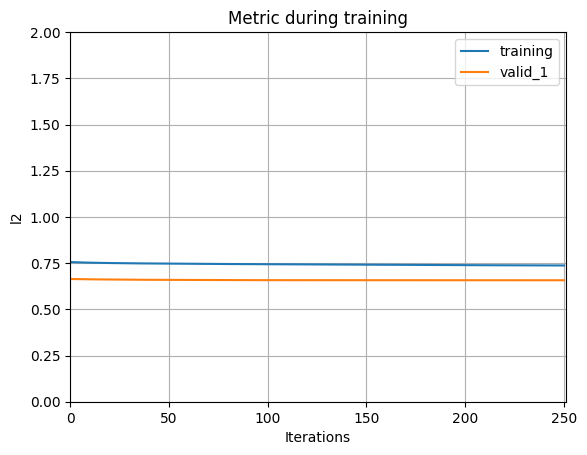

Val Weighted R2 score is: 0.010636682826810406


In [19]:
lgb_model = lgb_online_learning(train_df)

In [20]:
lgb_model

I:\Kaggle\kaggle_venvs\ml\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(device='gpu', early_stopping_round=30, feature_fraction=0.8,
              lambda_l2=100, learning_rate=0.05, n_estimators=90000,
              verbosity=-1)

In [21]:
if not os.path.exists(models_path):
    os.makedirs(models_path)

In [22]:
# save model
with open(models_path + "lgb_model.pkl", 'wb') as file:
    pickle.dump(lgb_model, file)

In [ ]:
# load model
with open(f"{models_path}/lgb_model.pkl", "rb") as f:
    lgb_model = pickle.load(f)

In [ ]:
val_df = train_df.filter(pl.col('date_id') > 1300)
print(val_df.shape)
val_df.head()

In [ ]:
lgb_model

In [ ]:
def val_online_learning(val_data, current_model, optuna_n_trials):
    val_data = val_data.clone()
    print('this is the initial validation data')
    print(val_data.shape)
    display(val_data.head())
    display(val_data.tail())
    i = 0
    val_date_ids = sorted(val_data['date_id'].unique())
    for date_id_v in val_date_ids:
        date_id_df = val_data.filter(pl.col('date_id') == date_id_v)
        print('this is date_id_df')
        print(date_id_df.shape)
        display(date_id_df.head())
        display(date_id_df.tail())
        
        X_train = date_id_df.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
        y_train = date_id_df['responder_6'].to_pandas()
        weights_train = date_id_df['weight'].to_pandas()

        #train_dataset = lgb.Dataset(data=X_train, label=y_train, weight=weights_train)

        val_data = val_data[date_id_df.shape[0]:]
        print('this is updated validation data')
        print(val_data.shape)
        display(val_data.head())
        display(val_data.tail())

        X_val = val_data.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
        y_val = val_data['responder_6'].to_pandas()
        weights_val = val_data['weight'].to_pandas()

        #val_dataset = lgb.Dataset(data=X_val, label=y_val, weight=weights_val)

        '''base_params = {
            'verbosity': -1,
            'learning_rate': 1,
            #'feature_fraction': 0.8,
            'device': 'gpu',
            'early_stopping_round': 30,
            #'lambda_l2': 100
        }'''

        '''updated_model = lgb.train(
            params=base_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, val_dataset],
            num_boost_round=90,
            init_model=current_model,
            callbacks=[log_evaluation(period=50), record_evaluation()]
        )'''
    
        '''online_model = LGBMRegressor(
            **base_params,
            n_estimators=100000
        )'''

        '''current_model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], callbacks=[log_evaluation(period=10)], init_model=current_model)
        #current_model.fit(X_val, y_val, sample_weight=weights_val, eval_set=[(X_val, y_val), (X_train, y_train)], eval_sample_weight=[weights_val, weights_train], callbacks=[log_evaluation(period=10)], init_model=current_model)

        #display(online_model)

        plt.figure()
        lgb.plot_metric(current_model)
        plt.ylim(0, 2)
        plt.show()
        
        val_preds = current_model.predict(X_val)
        
        return current_model'''

        base_params = {
            'verbosity': -1,
            #'learning_rate': 0.05,
            #'feature_fraction': 0.8,
            'device': 'gpu',
            'early_stopping_round': 10,
            #'lambda_l2': 100,
            'seed': 42
        }

        def objective(trial):

            params_to_tune = {
                'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.03),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 300),
                'num_leaves': trial.suggest_int('num_leaves', 20, 4000),
                'max_depth': trial.suggest_int('max_depth', 2, 3),
                'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 0.3),
                'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
                'lambda_l2': trial.suggest_float('lambda_l2', 1000, 2000)
            }

            online_model = LGBMRegressor(
                **base_params,
                **params_to_tune,
                n_estimators=100000
            )

            online_model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], init_model=current_model)
            #online_model.fit(X_val, y_val, sample_weight=weights_val, eval_set=[(X_val, y_val), (X_train, y_train)], eval_sample_weight=[weights_val, weights_train], callbacks=[log_evaluation(period=10)], init_model=current_model)

            '''plt.figure()
            lgb.plot_metric(online_model)
            plt.ylim(0, 2)
            plt.show()'''

            #best_iteration = online_model.best_iteration_
            #print(f"Best iteration: {best_iteration}")

            val_preds = online_model.predict(X_val)

            val_r2_score = r2_score(y_val, val_preds, sample_weight=weights_val)

            return val_r2_score

        with tqdm(total=optuna_n_trials, desc="Optimizing", unit="trial") as pbar:
    
            # Define a callback function to update the progress bar
            def progress_bar_callback(study, trial):
                pbar.update(1)
        
            study = optuna.create_study(direction="maximize")
            study.optimize(objective, n_trials=optuna_n_trials, callbacks=[progress_bar_callback])

        return study
    
        best_params = study.best_params

        online_model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], callbacks=[log_evaluation(period=10)], init_model=current_model)

        display(online_model)

        plt.figure()
        lgb.plot_metric(online_model)
        plt.ylim(0, 2)
        plt.show()
        
        val_preds = online_model.predict(X_val)

        print('Val Weighted R2 score is:', r2_score(y_val, val_preds, sample_weight=weights_val))

        return online_model

        if i > 20:
            return

        i += 1

In [ ]:
lgb_study = val_online_learning(val_df, lgb_model, 200)

In [ ]:
for param in lgb_study.best_params.keys():
    fig = plot_slice(lgb_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(lgb_study)

In [ ]:
lgb_study.best_params

In [ ]:
lgb_study.best_value

In [ ]:
lgb_params_df = pd.DataFrame({k:[lgb_study.best_params[k]] for k in lgb_study.best_params})

In [ ]:
lgb_params_df

In [ ]:
lgb_params_df.to_csv(models_path + 'lgb_params.csv', index=False)

In [ ]:
def create_params_dict(params_df):
    params_dict = {}
    for col in params_df.columns:
        v = params_df[col][0]
        if type(v) == np.int64:
            v = int(v)
        params_dict[col] = v

    return params_dict

In [ ]:
lgb_params_dict = create_params_dict(lgb_params_df)
lgb_params_dict

In [ ]:
cols = train_df.drop(['date_id', 'time_id', 'symbol_id']).columns
imp_df = pd.DataFrame(sorted(zip(cols, first_shap_importance)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

In [ ]:
print(imp_df.shape)

In [ ]:
imp_df

In [ ]:
plt.figure(figsize=(10, 40))
plt.title("Feature importances")
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
unimportant_df = imp_df[imp_df['Importance'] <= imp_df['Importance'].quantile(0.3)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df = train_df.drop(unimportant_cols)
print(train_selected_df.shape)
train_selected_df.head()

In [ ]:
second_shap_importance = lgb_train(train_selected_df, y_sr)